# Imports

#### Packages

In [8]:
import numpy as np
import pandas as pd
import json

import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

#### Files

In [9]:
import sqlite3
import pandas as pd

conn = sqlite3.connect('C:\\Users\\lplod\\OneDrive\\Dokumente\\SA_HFBoards\\forums.db')

query = "SELECT * FROM forum_data;"
df = pd.read_sql_query(query, conn)

print(df.head())

conn.close()

  username--style37         u-dt  \
0         kmwtrucks  Jul 2, 2024   
1           Bubba88  Jul 2, 2024   
2      statswatcher  Jul 2, 2024   
3        dj Mahoney  Jul 2, 2024   
4          ClydeLee  Jul 2, 2024   

                                           bbWrapper       forum  
0  I think maybe 75 pts. but still 5-8 worst. St ...  blackhawks  
1  Bulls picked 1st overall and 2nd overall in ad...  blackhawks  
2  kinda sucks if fate ends up such that this dra...  blackhawks  
3  Seems like we are a season behind the Red Wing...  blackhawks  
4  Hopefully we wind up with some picks with high...  blackhawks  


# Processing

In [15]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\lplod\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lplod\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\lplod\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\lplod\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt_tab.zip.


True

In [11]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [12]:
def preprocess_text(text):
    text = text.lower() # lowercase all text

    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE) # remove URLs

    text = re.sub(r'@\w+|#\w+|[^a-zA-Z\s]', '', text) # remove mentions, hashtags, special characters, numbers

    words = word_tokenize(text)

    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]  # remove stopwords and lemmatize words

    return ' '.join(words)

In [13]:
df

,username--style37,u-dt,bbWrapper,forum
0,kmwtrucks,"Jul 2, 2024",I think maybe 75 pts. but still 5-8 worst. St ...,blackhawks
1,Bubba88,"Jul 2, 2024",Bulls picked 1st overall and 2nd overall in ad...,blackhawks
2,statswatcher,"Jul 2, 2024",kinda sucks if fate ends up such that this dra...,blackhawks
3,dj Mahoney,"Jul 2, 2024",Seems like we are a season behind the Red Wing...,blackhawks
4,ClydeLee,"Jul 2, 2024",Hopefully we wind up with some picks with high...,blackhawks
...,...,...,...,...
1260,Troy McClure,Yesterday at 10:29 PM,That's actually great feedback to send to them...,stars
1261,Troy McClure,Yesterday at 10:32 PM,I think the thing with Bichsel is Nill did the...,stars
1262,starsfan86,Yesterday at 10:44 PM,Jim Depth Nill,stars
1263,Troy McClure,Yesterday at 10:50 PM,Last season was pretty crazy. The Stars had no...,stars


In [16]:
df = df.dropna(subset=['bbWrapper'])
df['cleaned_text'] = df['bbWrapper'].apply(preprocess_text)
df[['bbWrapper', 'cleaned_text']].head()

,bbWrapper,cleaned_text
0,I think maybe 75 pts. but still 5-8 worst. St ...,think maybe pt still worst st louis team could...
1,Bulls picked 1st overall and 2nd overall in ad...,bull picked st overall nd overall addition st ...
2,kinda sucks if fate ends up such that this dra...,kinda suck fate end draft one get top ten next...
3,Seems like we are a season behind the Red Wing...,seems like season behind red wing rebuild minu...
4,Hopefully we wind up with some picks with high...,hopefully wind pick higher potential kasperdan...


## Sentiment Analysis

### WordCloud

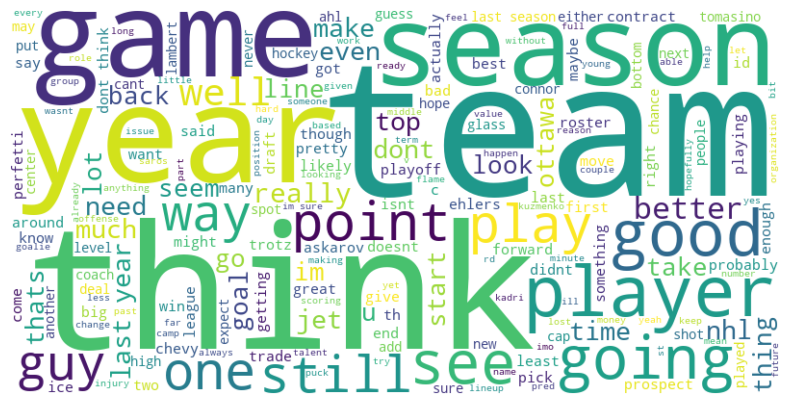

In [17]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

all_words = ' '.join(df['cleaned_text'])

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_words)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

### Label Assignment

In [18]:
from nltk.sentiment import SentimentIntensityAnalyzer

nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

def get_sentiment(text):
    sentiment = sia.polarity_scores(text)
    return sentiment

df['sentiment'] = df['cleaned_text'].apply(lambda x: sia.polarity_scores(x)['compound'])

df['sentiment_label'] = df['sentiment'].apply(lambda x: 'positive' if x > 0 else ('negative' if x < 0 else 'neutral'))

df[['cleaned_text', 'sentiment', 'sentiment_label']].head()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\lplod\AppData\Roaming\nltk_data...


,cleaned_text,sentiment,sentiment_label
0,think maybe pt still worst st louis team could...,-0.7184,negative
1,bull picked st overall nd overall addition st ...,-0.6377,negative
2,kinda suck fate end draft one get top ten next...,-0.2975,negative
3,seems like season behind red wing rebuild minu...,0.7579,positive
4,hopefully wind pick higher potential kasperdan...,0.4019,positive


### Topic Modelling

In [19]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

vectorizer = CountVectorizer(max_df=0.9, min_df=10, stop_words='english')
X = vectorizer.fit_transform(df['cleaned_text'])

lda = LatentDirichletAllocation(n_components=5, random_state=42)  # 5 topics
lda.fit(X)

def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_top_words = 10
display_topics(lda, vectorizer.get_feature_names_out(), no_top_words)

Topic 0:
cap tomasino way glass season know im contract dont trotz
Topic 1:
game ottawa play team dont hockey doesnt need think like
Topic 2:
year player team think season like guy play nhl good
Topic 3:
jet line perfetti connor ehlers like good team prospect chevy
Topic 4:
year team point season think dont like better playoff game


### Visualizations

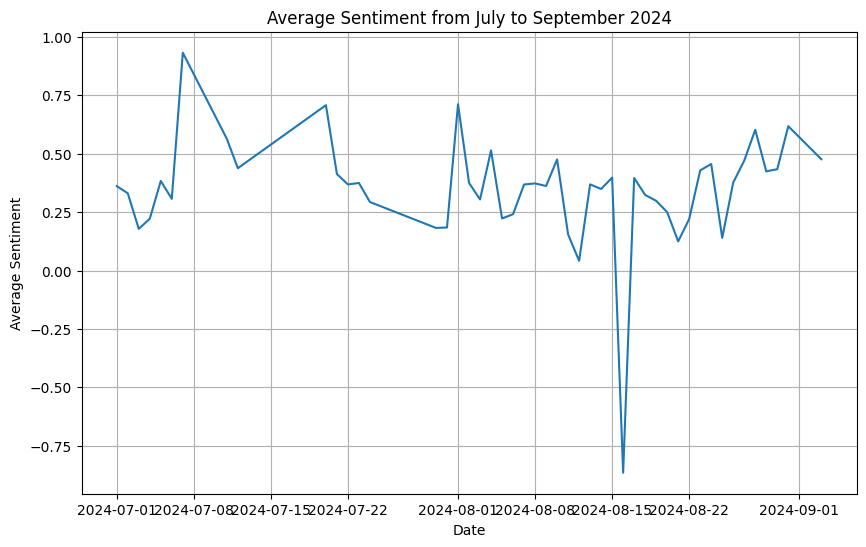

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

df['Date'] = pd.to_datetime(df['u-dt'], errors='coerce')

df = df.dropna(subset=['Date'])

start_date = '2024-07-01'
end_date = '2024-09-30'
filtered_df = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)]

sentiment_by_date = filtered_df.groupby('Date')['sentiment'].mean()

plt.figure(figsize=(10, 6))
sns.lineplot(x=sentiment_by_date.index, y=sentiment_by_date.values)
plt.title('Average Sentiment from July to September 2024')
plt.xlabel('Date')
plt.ylabel('Average Sentiment')
plt.grid(True)
plt.show()

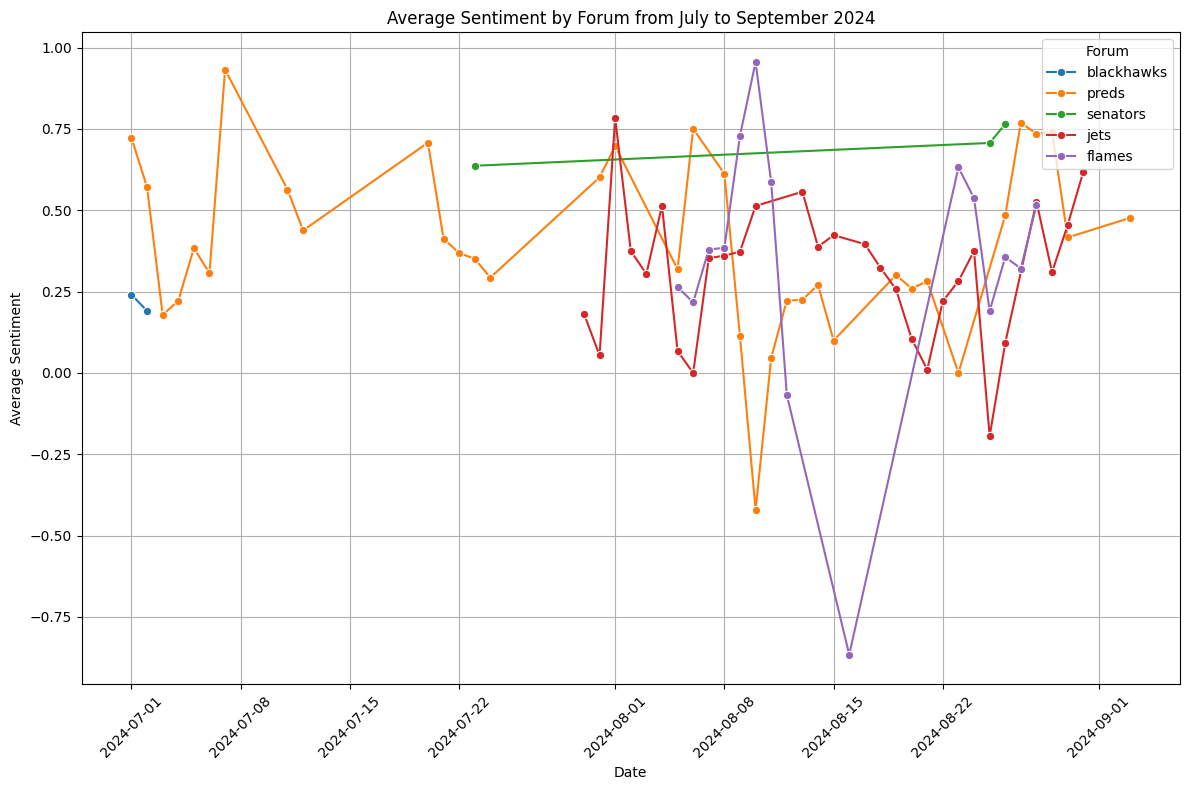

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert 'u-dt' column to datetime, if not already done
df['Date'] = pd.to_datetime(df['u-dt'], errors='coerce')

# Drop rows with missing dates
df = df.dropna(subset=['Date'])

# Filter the data for the date range between July 2024 and September 2024
start_date = '2024-07-01'
end_date = '2024-09-30'
filtered_df = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)]

# Group by both Date and forum, then calculate the average sentiment for each group
sentiment_by_forum_date = filtered_df.groupby(['Date', 'forum'])['sentiment'].mean().reset_index()

# Plotting the results
plt.figure(figsize=(12, 8))

# Use seaborn's lineplot to plot sentiment trends for each forum
sns.lineplot(data=sentiment_by_forum_date, x='Date', y='sentiment', hue='forum', marker='o')

# Add labels and title
plt.title('Average Sentiment by Forum from July to September 2024')
plt.xlabel('Date')
plt.ylabel('Average Sentiment')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend(title='Forum', loc='upper right')

# Show the plot
plt.tight_layout()
plt.show()

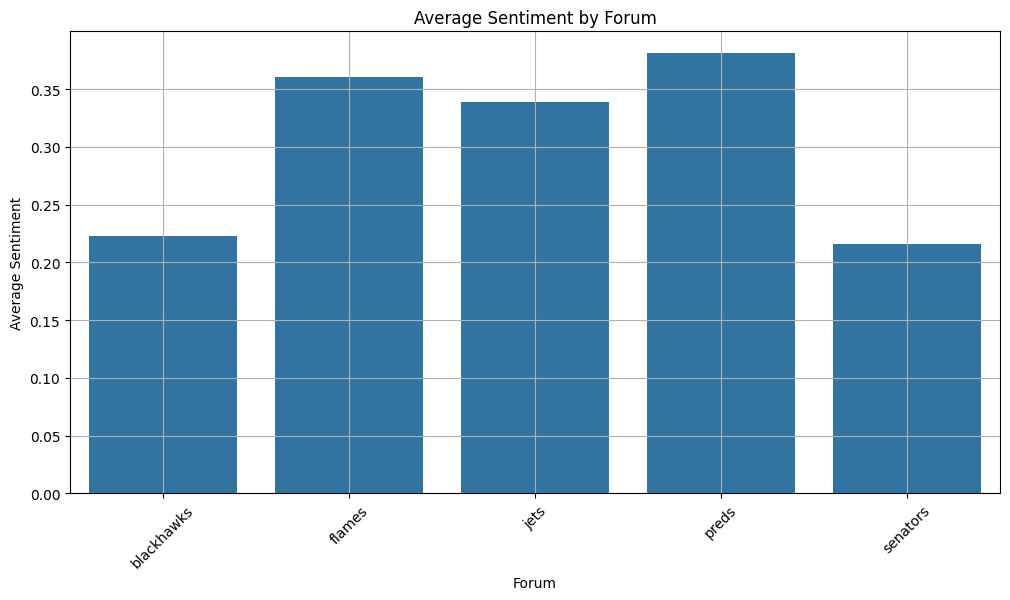

In [22]:
sentiment_by_forum = df.groupby('forum')['sentiment'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(x='forum', y='sentiment', data=sentiment_by_forum)
plt.title('Average Sentiment by Forum')
plt.xlabel('Forum')
plt.ylabel('Average Sentiment')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

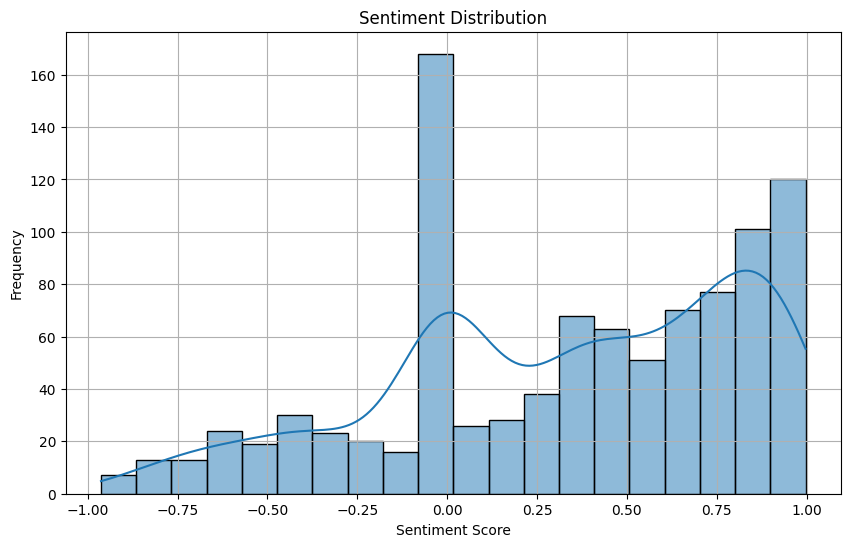

In [23]:
plt.figure(figsize=(10, 6))
sns.histplot(df['sentiment'], bins=20, kde=True)
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

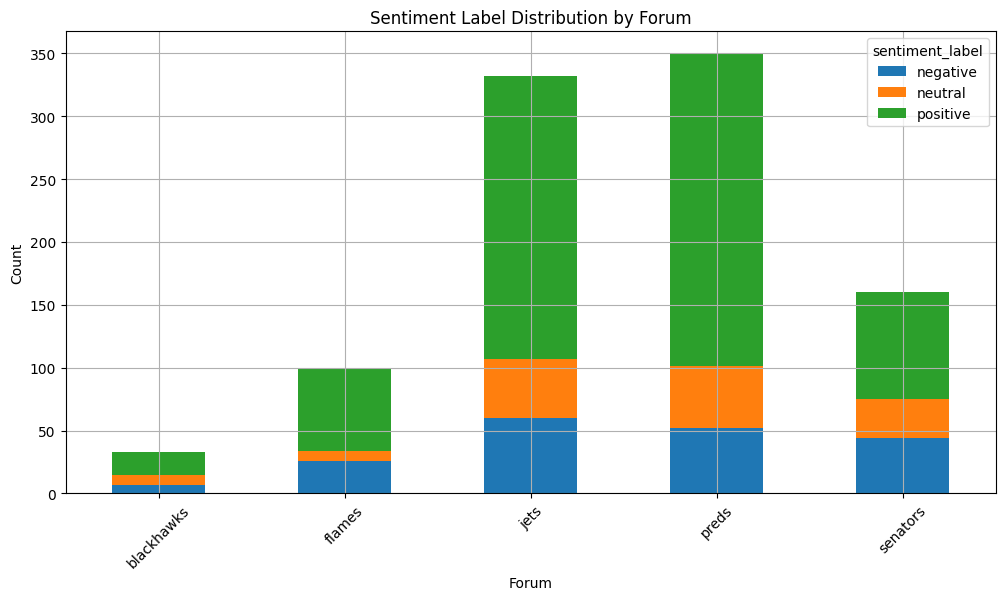

In [24]:
forum_sentiment = pd.crosstab(df['forum'], df['sentiment_label'])

forum_sentiment.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Sentiment Label Distribution by Forum')
plt.xlabel('Forum')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

## Classification Modelling

### Multinomial Naive Bayes

In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report

tfidf_vectorizer = TfidfVectorizer(max_df=0.9, min_df=10, stop_words='english')
X = tfidf_vectorizer.fit_transform(df['cleaned_text'])

y = df['forum']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)

y_pred = nb_model.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))

Accuracy: 0.6923076923076923
              precision    recall  f1-score   support

  blackhawks       0.00      0.00      0.00         3
      flames       1.00      0.25      0.40        20
        jets       0.64      0.76      0.69        67
       preds       0.68      0.85      0.76        75
    senators       0.94      0.50      0.65        30

    accuracy                           0.69       195
   macro avg       0.65      0.47      0.50       195
weighted avg       0.73      0.69      0.67       195



c:\Users\lplod\OneDrive\Dokumente\SA_HFBoards\my_venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\lplod\OneDrive\Dokumente\SA_HFBoards\my_venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\lplod\OneDrive\Dokumente\SA_HFBoards\my_venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

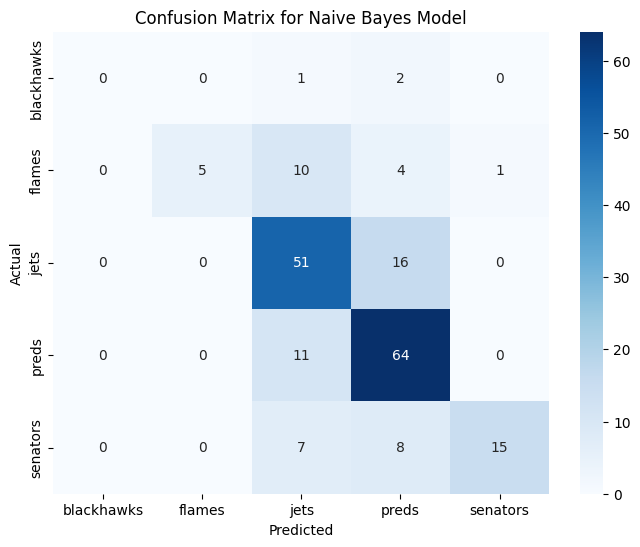

In [26]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred, labels=nb_model.classes_)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=nb_model.classes_, yticklabels=nb_model.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix for Naive Bayes Model')
plt.show()

### Logistic Regression

In [27]:
from sklearn.linear_model import LogisticRegression

# Initialize Logistic Regression
logreg_model = LogisticRegression(max_iter=1000)

# Fit the model
logreg_model.fit(X_train, y_train)

# Predict on the test set
y_pred_logreg = logreg_model.predict(X_test)

# Evaluate the performance
print(f"Accuracy: {accuracy_score(y_test, y_pred_logreg)}")
print(classification_report(y_test, y_pred_logreg))

Accuracy: 0.7076923076923077
              precision    recall  f1-score   support

  blackhawks       1.00      0.33      0.50         3
      flames       1.00      0.45      0.62        20
        jets       0.66      0.73      0.70        67
       preds       0.68      0.84      0.75        75
    senators       0.84      0.53      0.65        30

    accuracy                           0.71       195
   macro avg       0.84      0.58      0.64       195
weighted avg       0.74      0.71      0.70       195



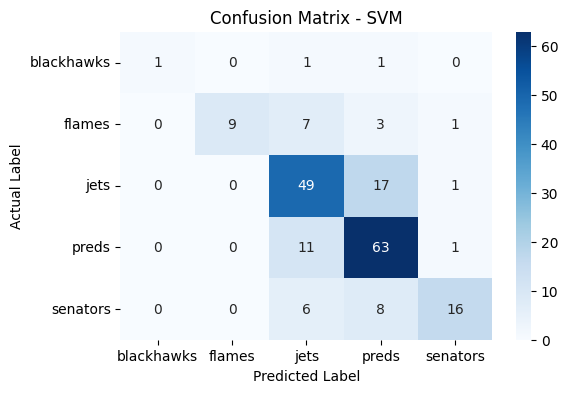

In [28]:
logreg_cm = confusion_matrix(y_test, y_pred_logreg)

plt.figure(figsize=(6, 4))
sns.heatmap(logreg_cm, annot=True, fmt='d', cmap='Blues', xticklabels=logreg_model.classes_, yticklabels=logreg_model.classes_)
plt.title('Confusion Matrix - SVM')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

### Support Vector Classifier (SVC)

In [29]:
from sklearn.svm import LinearSVC

# Initialize Linear SVC
svm_model = LinearSVC()

# Fit the model
svm_model.fit(X_train, y_train)

# Predict on the test set
y_pred_svm = svm_model.predict(X_test)

# Evaluate the performance
print(f"Accuracy: {accuracy_score(y_test, y_pred_svm)}")
print(classification_report(y_test, y_pred_svm))

Accuracy: 0.6871794871794872
              precision    recall  f1-score   support

  blackhawks       0.20      0.33      0.25         3
      flames       0.76      0.65      0.70        20
        jets       0.64      0.73      0.69        67
       preds       0.74      0.71      0.72        75
    senators       0.72      0.60      0.65        30

    accuracy                           0.69       195
   macro avg       0.61      0.60      0.60       195
weighted avg       0.70      0.69      0.69       195



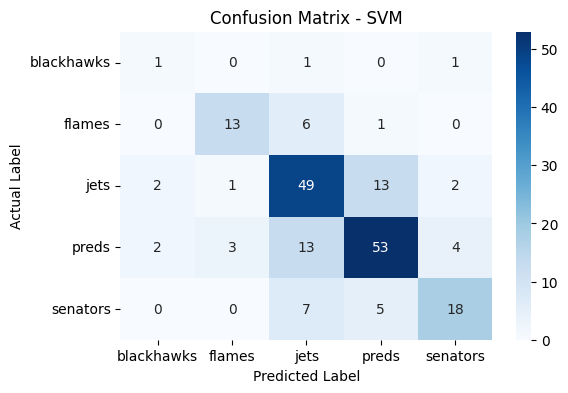

In [30]:
svm_cm = confusion_matrix(y_test, y_pred_svm)

plt.figure(figsize=(6, 4))
sns.heatmap(svm_cm, annot=True, fmt='d', cmap='Blues', xticklabels=svm_model.classes_, yticklabels=svm_model.classes_)
plt.title('Confusion Matrix - SVM')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

### Random Forest Classifier

In [31]:
from sklearn.ensemble import RandomForestClassifier

# Initialize Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the model
rf_model.fit(X_train, y_train)

# Predict on the test set
y_pred_rf = rf_model.predict(X_test)

# Evaluate the performance
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf)}")
print(classification_report(y_test, y_pred_rf))

Accuracy: 0.6923076923076923
              precision    recall  f1-score   support

  blackhawks       0.50      0.67      0.57         3
      flames       1.00      0.45      0.62        20
        jets       0.74      0.72      0.73        67
       preds       0.74      0.75      0.74        75
    senators       0.49      0.67      0.56        30

    accuracy                           0.69       195
   macro avg       0.69      0.65      0.64       195
weighted avg       0.72      0.69      0.69       195



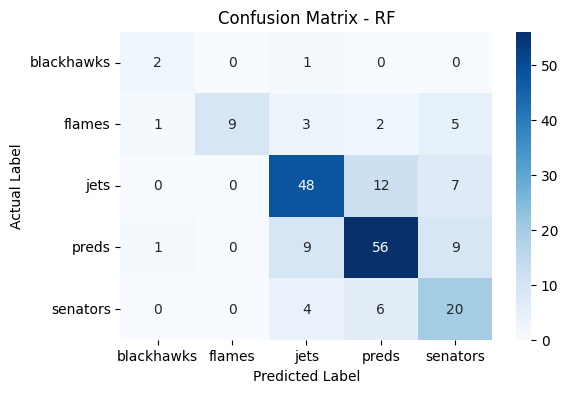

In [32]:
rf_cm = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(6, 4))
sns.heatmap(rf_cm, annot=True, fmt='d', cmap='Blues', xticklabels=rf_model.classes_, yticklabels=rf_model.classes_)
plt.title('Confusion Matrix - RF')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

### XGBoost

In [34]:
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

xgb_model.fit(X_train_xgb, y_train_xgb)

# Predict on the test set
y_pred_xgb = xgb_model.predict(X_test_xgb)

# Decode the numeric predictions back to the original labels
y_pred_xgb_labels = label_encoder.inverse_transform(y_pred_xgb)
y_test_labels = label_encoder.inverse_transform(y_test_xgb)

# Evaluate the performance
print(f"Accuracy: {accuracy_score(y_test_labels, y_pred_xgb_labels)}")
print(classification_report(y_test_labels, y_pred_xgb_labels))

c:\Users\lplod\OneDrive\Dokumente\SA_HFBoards\my_venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:22:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.676923076923077
              precision    recall  f1-score   support

  blackhawks       1.00      0.67      0.80         3
      flames       0.69      0.55      0.61        20
        jets       0.69      0.73      0.71        67
       preds       0.67      0.72      0.69        75
    senators       0.64      0.53      0.58        30

    accuracy                           0.68       195
   macro avg       0.74      0.64      0.68       195
weighted avg       0.68      0.68      0.67       195



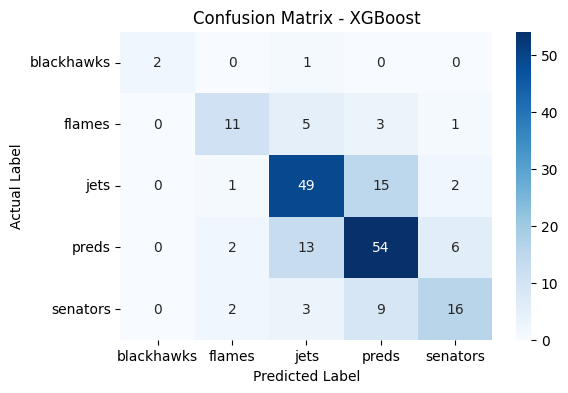

In [35]:
xgb_cm = confusion_matrix(y_test_labels, y_pred_xgb_labels)

plt.figure(figsize=(6, 4))
sns.heatmap(xgb_cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix - XGBoost')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

### KNN Classifier

In [36]:
from sklearn.neighbors import KNeighborsClassifier

# Initialize KNN
knn_model = KNeighborsClassifier(n_neighbors=5)

# Fit the model
knn_model.fit(X_train, y_train)

# Predict on the test set
y_pred_knn = knn_model.predict(X_test)

# Evaluate the performance
print(f"Accuracy: {accuracy_score(y_test, y_pred_knn)}")
print(classification_report(y_test, y_pred_knn))

Accuracy: 0.2717948717948718
              precision    recall  f1-score   support

  blackhawks       0.05      0.33      0.08         3
      flames       0.00      0.00      0.00        20
        jets       0.34      0.43      0.38        67
       preds       0.44      0.11      0.17        75
    senators       0.24      0.50      0.33        30

    accuracy                           0.27       195
   macro avg       0.22      0.27      0.19       195
weighted avg       0.33      0.27      0.25       195



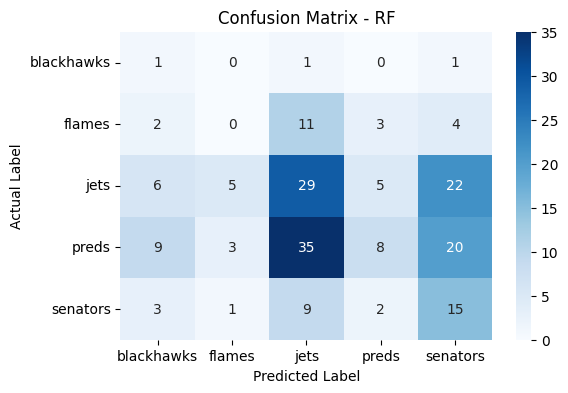

In [37]:
knn_cm = confusion_matrix(y_test, y_pred_knn)

plt.figure(figsize=(6, 4))
sns.heatmap(knn_cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix - RF')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

## Clustering

### K-Means (3)

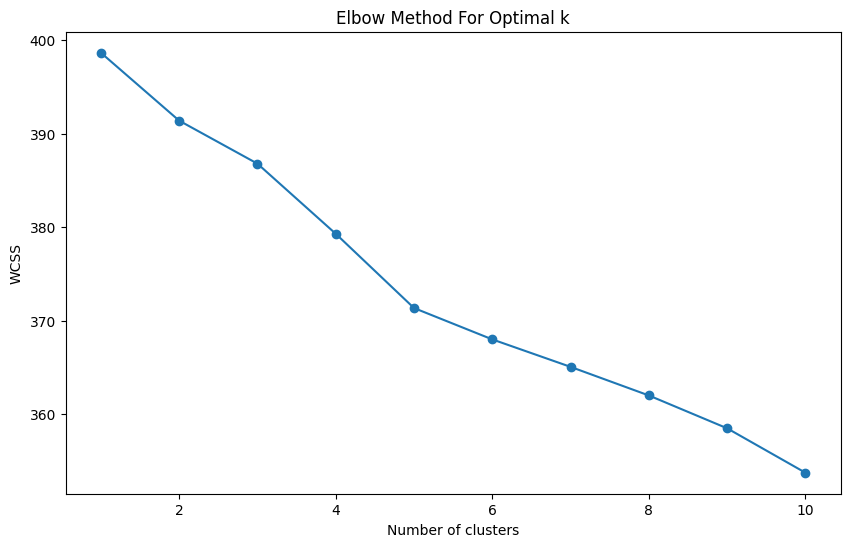

In [38]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

tfidf_vectorizer = TfidfVectorizer(max_df=0.9, min_df=5, stop_words='english')

X = tfidf_vectorizer.fit_transform(df['cleaned_text'])

from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=100)
X_reduced = svd.fit_transform(X)

# Range of clusters to test
range_n_clusters = range(1, 11)
wcss = []

# Compute WCSS for different numbers of clusters
for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(X_reduced)
    wcss.append(kmeans.inertia_)

# Plot WCSS
plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters, wcss, marker='o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [39]:
num_clusters = 5
kmeans = KMeans(n_clusters=num_clusters, random_state=42)

clusters = kmeans.fit_predict(X_reduced)

df['cluster'] = clusters

In [40]:
def print_top_terms_per_cluster(model, feature_names, n_top_terms=10):
    for cluster_num in range(model.n_clusters):
        top_terms_idx = np.argsort(model.cluster_centers_[cluster_num])[-n_top_terms:]
        top_terms = [feature_names[i] for i in top_terms_idx]
        print(f"Cluster {cluster_num}: {', '.join(top_terms)}")

print_top_terms_per_cluster(kmeans, tfidf_vectorizer.get_feature_names_out())

Cluster 0: air, agency, american, av, andersson, ahead, action, added, ability, absolutely
Cluster 1: aging, ahead, addition, actual, actually, adam, absolutely, able, accurate, ability
Cluster 2: actual, backup, allow, alot, afanaseyev, agent, accurate, actually, action, ability
Cluster 3: agreed, ahl, age, arbitration, basically, added, aging, anaheim, adding, ability
Cluster 4: arent, allow, area, adam, anymore, afanaseyev, added, action, ability, able


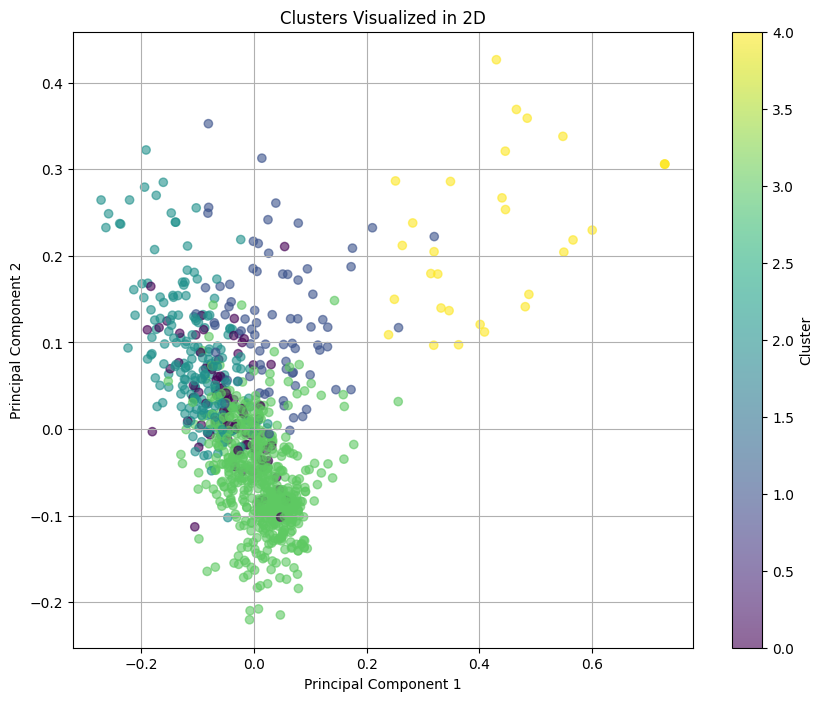

In [41]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_reduced)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df['cluster'], cmap='viridis', alpha=0.6)
plt.colorbar(scatter, label='Cluster')
plt.title('Clusters Visualized in 2D')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()

In [42]:
# Calculate sentiment distribution per cluster
sentiment_distribution = df.groupby('cluster')['sentiment'].mean().reset_index()
print(sentiment_distribution)

   cluster  sentiment
0        0   0.377639
1        1   0.477879
2        2   0.541500
3        3   0.245702
4        4   0.183263


In [43]:
forum_distribution = df.groupby(['cluster', 'forum']).size().unstack().fillna(0)
print(forum_distribution)

forum    blackhawks  flames   jets  preds  senators
cluster                                            
0               0.0     1.0   77.0    3.0       1.0
1               0.0     6.0   23.0   19.0      30.0
2               9.0    40.0   67.0   68.0       9.0
3              24.0    53.0  165.0  260.0      90.0
4               0.0     0.0    0.0    0.0      30.0


Cluster 0 Word Cloud:


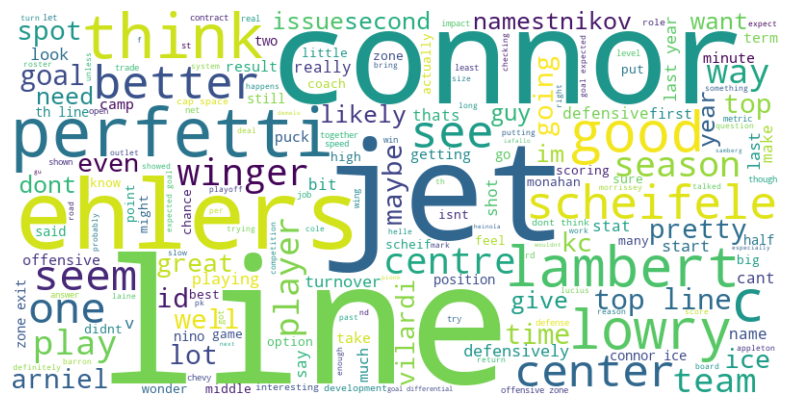

Cluster 1 Word Cloud:


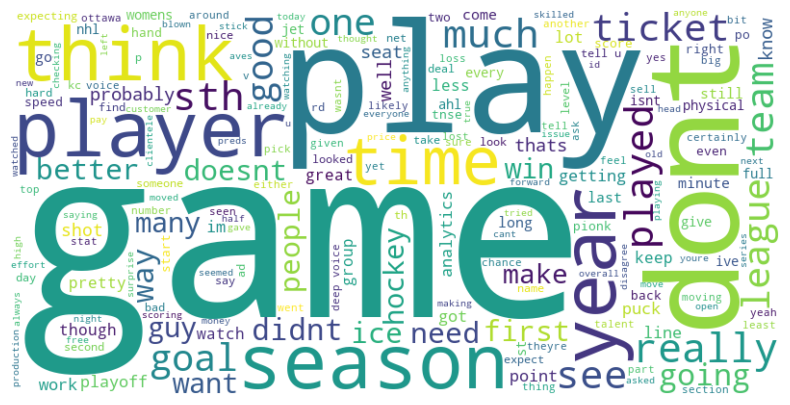

Cluster 2 Word Cloud:


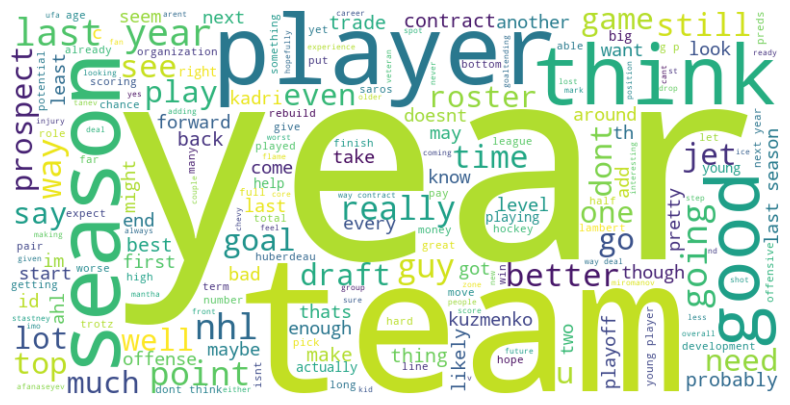

Cluster 3 Word Cloud:


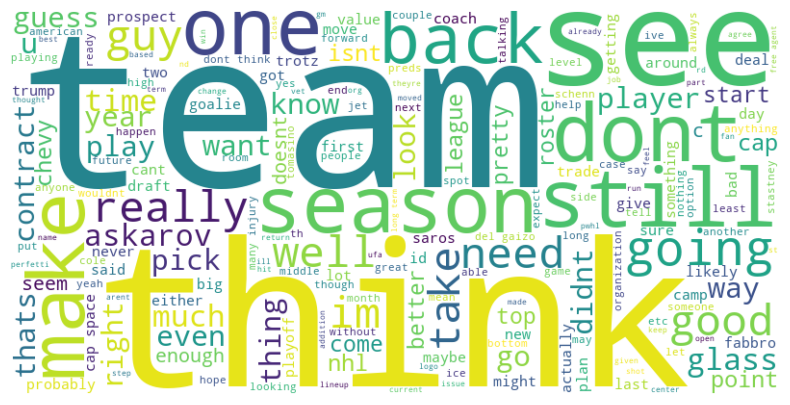

Cluster 4 Word Cloud:


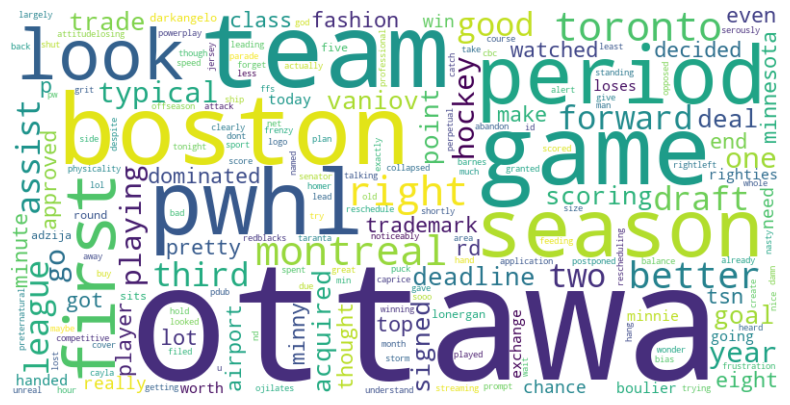

In [44]:
from wordcloud import WordCloud

# Function to create and plot word cloud for a cluster
def plot_word_cloud(text):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

# Generate and plot word clouds for each cluster
for cluster_num in range(num_clusters):
    cluster_text = ' '.join(df[df['cluster'] == cluster_num]['cleaned_text'])
    print(f"Cluster {cluster_num} Word Cloud:")
    plot_word_cloud(cluster_text)

### Cluster Analysis

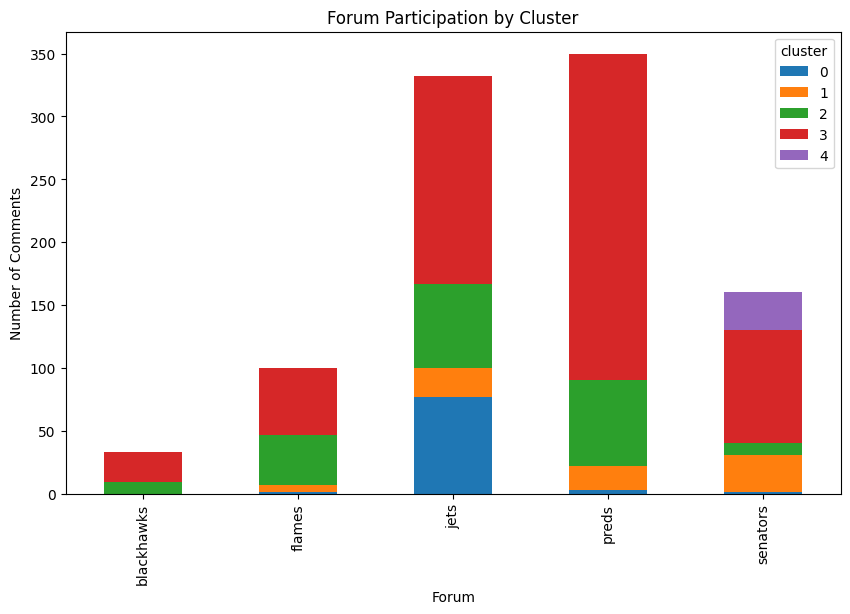

In [45]:
# Count of forum participation in each cluster
forum_cluster_distribution = df.groupby(['forum', 'cluster']).size().unstack(fill_value=0)

# Plot the forum distribution in each cluster
forum_cluster_distribution.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Forum Participation by Cluster')
plt.xlabel('Forum')
plt.ylabel('Number of Comments')
plt.show()